In [ ]:
########################################################################

# import the necessary packages
import numpy as np
import argparse
import imutils
import cv2 # pip install opencv-python
import matplotlib.pyplot as plt
# import torch
# import torchvision.transforms as T

from IPython.display import display, Image
from easydict import EasyDict
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
# from torchvision import models
# fcn  = models.segmentation.fcn_resnet101(pretrained=True, progress=True, num_classes=21, aux_loss=None).eval()
# dlab = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True, num_classes=21, aux_loss=None).eval()
# from PIL import Image as PILImage
 
## construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-i", "--image", required=False, help="path to the input image")
#ap.add_argument("-w", "--width", type=float, required=False, help="width of the left-most object in the image (in inches)")
## Do args = vars(ap.parse_args() in Jupyter
#args = EasyDict({
#    "image": 10,
#    "width": 10
#})

# https://www.pyimagesearch.com/2016/03/28/measuring-size-of-objects-in-an-image-with-opencv/

########################################################################

In [ ]:
### DECLARE GENERAL FUNCTIONS
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def order_points(pts):
    # sort the points based on their x-coordinates
    xSorted = pts[np.argsort(pts[:, 0]), :]
    
    # grab the left-most and right-most points from the sorted
    # x-roodinate points
    leftMost = xSorted[:2, :]
    rightMost = xSorted[2:, :]
    
    # now, sort the left-most coordinates according to their
    # y-coordinates so we can grab the top-left and bottom-left
    # points, respectively
    leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
    (tl, bl) = leftMost
    
    # now that we have the top-left coordinate, use it as an
    # anchor to calculate the Euclidean distance between the
    # top-left and right-most points; by the Pythagorean
    # theorem, the point with the largest distance will be
    # our bottom-right point
    D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
    (br, tr) = rightMost[np.argsort(D)[::-1], :]
    
    # return the coordinates in top-left, top-right,
    # bottom-right, and bottom-left order
    return np.array([tl, tr, br, bl], dtype="float32")

In [ ]:
def measureImg(orimgname_, imgname_, refIsXval, refImg, refVal, edgeType, minObjArea, invertPimg, Threshold=128, denoise=0):
    ''' <required> imgname_ : 'path + image file name' as a string of the image to analyze
    
        <required> fineTuning : parameter used to adjust the "pixels per metric", the purpose is to
                                tune this value to match the dimensions of the refetence object
        
        <required> edgeType : can be 'edged', 'dilated', or 'eroded' as a string
                              'edged'   : performs the Canny edge detection algorithm
                              'dilated' : performs 'edged' and increases the object area to accentuate
                                          features
                              'eroded'  : performs 'dilated' and erodes away the boundaries of
                                          foreground object to diminish the features of an image
        
        <required> minObjArea : defines the minimum object size to be analyzed, ignore the object if
                                the contour is not sufficiently large
        
        <required> invertPimg : Boolean
                                True  : implements a binary version of the original image before the
                                        detection algorithm
                                False : implements a grey-scale version of the original image before
                                        the detection algorithm
        
        <optional> cannyThreshold=[50, 100] : only useful if invertPimg=False [minVal, maxVal]
                                              any edges with intensity gradient more than maxVal are
                                              sure to be edges and those below minVal are sure to be
                                              non-edges, so discarded.
        
        <optional> binThresh=128 : only useful if invertPimg=True
                                   defines a threshold when creating a binary image, 128 is the middle
                                   of black and white in grey scale '''
    
    #TUNE fineTuning TO MATCH THE REFERENCE OBJECT

    ### IMAGE PRE-PROCESSING
    # load the image
    orimg = cv2.imread(orimgname_)
    img = cv2.imread(imgname_)
    
    # Image Denoising
    dst = cv2.fastNlMeansDenoisingColored(
        src=img,
        dst=None,
        h=denoise,
        hColor=denoise,
        templateWindowSize=7,
        searchWindowSize=21)

    # Convert to grayscale
    grey = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

    # define a threshold, 128 is the middle of black and white in grey scale
    thresh = Threshold #256/2

    # assign blue channel to zeros
    binary = cv2.threshold(grey, thresh, 256, cv2.THRESH_BINARY)[1]

#     # Inverting the colors
#     invert = abs(255 - binary)
    
    ### IMAGE PROCESSING
    # perform edge detection, then perform a dilation + erosion to
    
    # close gaps in between object edges
    if invertPimg:
        edged = cv2.Canny(binary, Threshold, Threshold)
    else:
        edged = cv2.Canny(grey, Threshold, Threshold)

    dilated = cv2.dilate(edged, None, iterations=1)
    eroded = cv2.erode(dilated, None, iterations=1)

    if edgeType == "dilated":
        Pimg = dilated
    elif edgeType == "eroded":
        Pimg = eroded
    else:
        Pimg = edged
    
    # Show and save image
    print()
    print('Image to Process:')
    imgname='./img_out.png'
    cv2.imwrite(imgname,Pimg)
    display(Image(filename=imgname))
    
    ### GET IMAGE MEASUREMENTS
    # find contours in the edge map
    cnts = cv2.findContours(Pimg.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # sort the contours from left-to-right and initialize the
    # 'pixels per metric' calibration variable
    (cnts, _) = contours.sort_contours(cnts)
    
    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    # (in this case, inches) to match the reference object
    pixelsPerMetric = None
    i = 0
    for c in reversed(cnts):
        if cv2.contourArea(c) < minObjArea:
            continue
            
        if i == refImg and pixelsPerMetric is None:
            box = cv2.minAreaRect(c)
            box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
            box = np.array(box, dtype="int")
            box = perspective.order_points(box)
            (tl, tr, br, bl) = box
            (tltrX, tltrY) = midpoint(tl, tr)
            (blbrX, blbrY) = midpoint(bl, br)
            (tlblX, tlblY) = midpoint(tl, bl)
            (trbrX, trbrY) = midpoint(tr, br)
            dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
            dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
            if refIsXval:
                pixelsPerMetric = dB*(25400000/refVal)
            else:
                pixelsPerMetric = dA*(25400000/refVal)
        i += 1
        #print(pixelsPerMetric)

    # loop over the contours individually
    i = 0
    for c in reversed(cnts):
        # if the contour is not sufficiently large, ignore it
        if cv2.contourArea(c) < minObjArea:
            continue

        # compute the rotated bounding box of the contour
        orig = orimg.copy()
        box = cv2.minAreaRect(c)        
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        # order the points in the contour such that they appear
        # in top-left, top-right, bottom-right, and bottom-left
        # order, then draw the outline of the rotated bounding
        # box
        box = perspective.order_points(box)
        cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 1)

        # loop over the original points and draw them
        for (x, y) in box:
            cv2.circle(orig, (int(x), int(y)), 2, (0, 0, 255), -1)

        # unpack the ordered bounding box, then compute the midpoint
        # between the top-left and top-right coordinates, followed by
        # the midpoint between bottom-left and bottom-right coordinates
        (tl, tr, br, bl) = box
#         print(box, '\n', order_points(box))
#         (tl, tr, br, bl) = order_points(box)
        (tltrX, tltrY) = midpoint(tl, tr)
        (blbrX, blbrY) = midpoint(bl, br)

        # compute the midpoint between the top-left and top-right points,
        # followed by the midpoint between the top-righ and bottom-right
        (tlblX, tlblY) = midpoint(tl, bl)
        (trbrX, trbrY) = midpoint(tr, br)

        # draw the midpoints on the image
        cv2.circle(orig, (int(tltrX), int(tltrY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(blbrX), int(blbrY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(tlblX), int(tlblY)), 2, (255, 0, 0), -1)
        cv2.circle(orig, (int(trbrX), int(trbrY)), 2, (255, 0, 0), -1)

        # draw lines between the midpoints
        cv2.line(orig, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 1)
        cv2.line(orig, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 1)

        # compute the Euclidean distance between the midpoints
        dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
        dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
            
        # compute the size of the object
        dimA = dA / pixelsPerMetric
        dimB = dB / pixelsPerMetric

        # convert inches to nm
        dimA = dimA*25400000
        dimB = dimB*25400000
        
        # draw the object sizes on the image
        txtcolor=(255, 171, 0)
        cv2.putText(orig, "{:.2f}nm".format(dimB),
                    (int(tltrX - 15), int(tltrY - 10)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, txtcolor, 2, 5)
        cv2.putText(orig, "{:.2f}nm".format(dimA),
                    (int(trbrX + 10), int(trbrY)), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, txtcolor, 2)

        # Show and save output image
        print()
        print('Measurements in progress ... ' + str(i))
        print('dimX=' + str(round(dimB,2)) + 'nm;  dimY=' + str(round(dimA,2)) + 'nm;')
        imgname='./img_out.png'
        cv2.imwrite(imgname,orig)
        display(Image(filename=imgname))
        i += 1

In [ ]:
help(measureImg);
display(Image(filename='./img/UScoinRef.png'));
measureImg(
    './img/example_01.png',
    './img/example_01.png',
    True, 5, 24260000,
    'eroded',
    100,
    False,
    Threshold=150,
    denoise=15);

---

In [ ]:
# horizontal fibers
measureImg('./img/Camillo2013_00_orig.png',
           './img/Camillo2013_00_orig.png',
           True, 4, 100000,
           'eroded',
           50,
           True,
           Threshold=160,
           denoise=0);

In [ ]:
# vertical fibers
measureImg('./img/Camillo2013_00_orig.png',
           './img/Camillo2013_00_orig.png',
           True, 2, 100000,
           'eroded',
           100,
           False,
           Threshold=265,
           denoise=10);

In [ ]:
# distance in between
measureImg('./img/Camillo2013_00_orig.png',
           './img/Camillo2013_00_orig.png',
           True, 2, 100000,
           'eroded',
           100,
           True,
           Threshold=165,
           denoise=0);

In [ ]:
measureImg('./img/Camillo2013_01_orig.png',
           './img/Camillo2013_01.png',
           True, 4, 200,
           'eroded',
           500,
           True, #T=binary;F=greyscale;
           Threshold=45,
           denoise=20);

In [ ]:
measureImg('./img/Camillo2013_02_orig.png',
           './img/Camillo2013_02.png',
           True, 1, 500,
           'eroded',
           300,
           True, #T=binary;F=greyscale;
           Threshold=50,
           denoise=10);

---

In [ ]:
# DOES NOT MATCH w/reported value range of 1.5 to 3 um
# measureImg('./img/Duan2017_00_orig.png',
#            './img/Duan2017_00.png',
#            True, 6, 500000, #0.00666,
#            'eroded',
#            50,
#            False, #T=binary;F=greyscale;
#            Threshold=155,
#            denoise=0);

In [ ]:
# DOES NOT MATCH w/reported value range of 1.5 to 3 um
# measureImg('./img/Duan2017_01_orig.png',
#            './img/Duan2017_01.png',
#            True, 2, 1000, #0.00666,
#            'canny',
#            100,
#            False, #T=binary;F=greyscale;
#            Threshold=200,
#            denoise=0);

In [ ]:
# DOES NOT MATCH w/reported value range of 1.5 to 3 um
# measureImg('./img/Duan2017_02_orig.png',
#            './img/Duan2017_02.png',
#            True, 1, 200000, #0.00666,
#            'canny',
#            50,
#            False, #T=binary;F=greyscale;
#            Threshold=100,
#            denoise=0);

---

In [ ]:
measureImg('./img/Gupta2007_00_orig.png',
           './img/Gupta2007_00_dis.png',
           True, 1, 100000, #0.00666,
           'eroded',
           50,
           False, #T=binary;F=greyscale;
           Threshold=125,
           denoise=20);

In [ ]:
measureImg('./img/Gupta2007_00_orig.png',
           './img/Gupta2007_00.png',
           True, 8, 100000, #0.00666,
           'eroded',
           50,
           False, #T=binary;F=greyscale;
           Threshold=45,
           denoise=10);

In [ ]:
measureImg('./img/Gupta2007_01_orig.png',
           './img/Gupta2007_01_dis.png',
           True, 3, 100000, #0.00666,
           'canny',
           100,
           True, #T=binary;F=greyscale;
           Threshold=140,
           denoise=20);

In [ ]:
measureImg('./img/Gupta2007_01_orig.png',
           './img/Gupta2007_01.png',
           True, 6, 100000, #0.00666,
           'eroded',
           150,
           False, #T=binary;F=greyscale;
           Threshold=145,
           denoise=10);

---

In [ ]:
measureImg('./img/Jiang2018_00_orig.png',
           './img/Jiang2018_00.png',
           True, 6, 500000, #0.00666,
           'eroded',
           50,
           False, #T=binary;F=greyscale;
           Threshold=140,
           denoise=0);

In [ ]:
measureImg('./img/Jiang2018_00_orig.png',
           './img/Jiang2018_00_dis.png',
           True, 0, 500000, #0.00666,
           'eroded',
           50,
           True, #T=binary;F=greyscale;
           Threshold=192,
           denoise=0);

In [ ]:
measureImg('./img/Jiang2018_01_orig.png',
           './img/Jiang2018_01_dis.png',
           True, 9, 500000, #0.00666,
           'canny',
           50,
           True, #T=binary;F=greyscale;
           Threshold=170,
           denoise=1);

---

In [ ]:
measureImg('./img/Min2013_00_orig.png',
           './img/Min2013_00.png',
           True, 1, 100, #0.00666,
           'eroded',
           500,
           True, #T=binary;F=greyscale;
           Threshold=85,
           denoise=5);

In [ ]:
measureImg('./img/Min2013_01_orig.png',
           './img/Min2013_01.png',
           True, 1, 500, #0.00666,
           'eroded',
           500,
           False, #T=binary;F=greyscale;
           Threshold=20,
           denoise=10);

In [ ]:
measureImg('./img/Min2013_02_orig.png',
           './img/Min2013_02.png',
           True, 1, 500, #0.00666,
           'eroded',
           500,
           False, #T=binary;F=greyscale;
           Threshold=90,
           denoise=10);

In [ ]:
measureImg('./img/Min2013_03_orig.png',
           './img/Min2013_03.png',
           True, 1, 500, #0.00666,
           'eroded',
           500,
           False, #T=binary;F=greyscale;
           Threshold=60,
           denoise=10);

---

In [ ]:
measureImg('./img/Sun2006a_00_orig.png',
           './img/Sun2006a_00.png',
           True, 2, 500, #0.00666,
           'canny',
           250,
           False, #T=binary;F=greyscale;
           Threshold=20,
           denoise=25);

In [ ]:
measureImg('./img/Sun2006a_01_orig.png',
           './img/Sun2006a_01.png',
           True, 1, 100000, #0.00666,
           'canny',
           250,
           False, #T=binary;F=greyscale;
           Threshold=40,
           denoise=15);

---

In [ ]:
measureImg('./img/Wang2015_00_orig.png',
           './img/Wang2015_00.png',
           True, 5, 50000, #0.00666,
           'eroded',
           250,
           True, #T=binary;F=greyscale;
           Threshold=120,
           denoise=0);

---

In [ ]:
measureImg('./img/Xu2014_00_orig.png',
           './img/Xu2014_00.png',
           True, 5, 1000, #0.00666,
           'eroded',
           250,
           True, #T=binary;F=greyscale;
           Threshold=40,
           denoise=10);

---

In [ ]:
measureImg('./img/Xue2014_00_orig.png',
           './img/Xue2014_00.png',
           True, 4, 200000, #0.00666,
           'canny',
           250,
           True, #T=binary;F=greyscale;
           Threshold=95,
           denoise=10);

In [ ]:
measureImg('./img/Xue2014_01_orig.png',
           './img/Xue2014_01.png',
           True, 1, 2000, #0.00666,
           'canny',
           250,
           False, #T=binary;F=greyscale;
           Threshold=140,
           denoise=15);

---

In [ ]:
measureImg('./img/Zheng2014_00_orig.png',
           './img/Zheng2014_00.png',
           True, 1, 500000,
           'canny',
           50,
           False, #T=binary;F=greyscale;
           Threshold=40,
           denoise=5);

In [ ]:
measureImg('./img/Zheng2014_01_orig.png',
           './img/Zheng2014_01.png',
           True, 2, 500000,
           'canny',
           50,
           False, #T=binary;F=greyscale;
           Threshold=50,
           denoise=5);

In [ ]:
measureImg('./img/Zheng2014_02_orig.png',
           './img/Zheng2014_02.png',
           True, 0, 500000,
           'canny',
           50,
           False, #T=binary;F=greyscale;
           Threshold=50,
           denoise=5);

---

In [ ]:
measureImg('./img/Bu2012_00_orig.png',
           './img/Bu2012_00.png',
           True, 3, 100000,
           'canny',
           50,
           True, #T=binary;F=greyscale;
           Threshold=137,
           denoise=7);

In [ ]:
measureImg('./img/Bu2012_01_orig.png',
           './img/Bu2012_01.png',
           True, 6, 100000,
           'canny',
           50,
           False, #T=binary;F=greyscale;
           Threshold=26,
           denoise=0);

In [ ]:
measureImg('./img/Bu2012_02_orig.png',
           './img/Bu2012_02.png',
           True, 4, 2000,
           'canny',
           50,
           True, #T=binary;F=greyscale;
           Threshold=128,
           denoise=5);

In [ ]:
measureImg('./img/Bu2012_03_orig.png',
           './img/Bu2012_03.png',
           True, 3, 2000,
           'eroded',
           50,
           True, #T=binary;F=greyscale;
           Threshold=160,
           denoise=5);

---

In [ ]:
measureImg('./img/F4a_Lei2015_orig.png',
           './img/F4a_Lei2015_orig.png',
           True, 1, 1000000,
           'canny',
           250,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/F4a_Lei2015_orig.png',
           './img/F4a_nc_Lei2015.png',
           True, 4, 1000000,
           'canny',
           250,
           False,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/F4b_nc_Lei2015_orig.png',
           './img/F4b_nc_Lei2015.png',
           True, 1, 1000000,
           'canny',
           150,
           False,
           Threshold=150,
           denoise=10);

---

In [ ]:
measureImg('./img/Yousefi2020_00_orig.png',
           './img/Yousefi2020_00.png',
           True, 0, 10000,
           'canny',
           250,
           True,
           Threshold=230,
           denoise=10);

---

In [ ]:
measureImg('./img/Zhou2011_00_orig.png',
           './img/Zhou2011_00.png',
           True, 2, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_01_orig.png',
           './img/Zhou2011_01.png',
           True, 2, 20000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_02_orig.png',
           './img/Zhou2011_02.png',
           True, 3, 20000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_03_orig.png',
           './img/Zhou2011_03.png',
           True, 3, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_04_orig.png',
           './img/Zhou2011_04.png',
           True, 2, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_05_orig.png',
           './img/Zhou2011_05.png',
           True, 3, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_06_orig.png',
           './img/Zhou2011_06.png',
           True, 3, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_07_orig.png',
           './img/Zhou2011_07.png',
           True, 1, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_08_orig.png',
           './img/Zhou2011_08.png',
           True, 3, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_09_orig.png',
           './img/Zhou2011_09.png',
           True, 3, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

In [ ]:
measureImg('./img/Zhou2011_10_orig.png',
           './img/Zhou2011_10.png',
           True, 4, 100000,
           'canny',
           50,
           True,
           Threshold=150,
           denoise=10);

---

In [ ]:
measureImg('./img/Shen2016_00_orig.png',
           './img/Shen2016_00.png',
           True, 2, 40000, #0.00666,
           'edged',
           50,
           True, #T=binary;F=greyscale;
           Threshold=32,
           denoise=0);

---

In [ ]:
measureImg('./img/Shin2019_00_orig.png',
           './img/Shin2019_00.png',
           True, 1, 10000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Shin2019_01_orig.png',
           './img/Shin2019_01.png',
           True, 2, 10000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Shin2019_02_orig.png',
           './img/Shin2019_02.png',
           True, 3, 10000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Shin2019_03_orig.png',
           './img/Shin2019_03.png',
           True, 1, 10000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Shin2019_04_orig.png',
           './img/Shin2019_04.png',
           True, 2, 10000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Shin2019_05_orig.png',
           './img/Shin2019_05.png',
           True, 3, 10000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

---

In [ ]:
measureImg('./img/Choi2017_00_orig.png',
           './img/Choi2017_00.png',
           True, 8, 200000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

---

In [ ]:
measureImg('./img/GaofengZheng2010_00_orig.png',
           './img/GaofengZheng2010_00.png',
           True, 0, 20000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/GaofengZheng2010_01_orig.png',
           './img/GaofengZheng2010_01.png',
           True, 0, 20000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/GaofengZheng2010_02_orig.png',
           './img/GaofengZheng2010_02.png',
           True, 0, 20000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/GaofengZheng2010_03_orig.png',
           './img/GaofengZheng2010_03.png',
           True, 3, 10000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

---

In [ ]:
measureImg('./img/Zhu2016_00_orig.png',
           './img/Zhu2016_00.png',
           True, 0, 200000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Zhu2016_01_orig.png',
           './img/Zhu2016_01.png',
           True, 2, 200000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Zhu2016_02_orig.png',
           './img/Zhu2016_02.png',
           True, 4, 200000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Zhu2016_03_orig.png',
           './img/Zhu2016_03.png',
           True, 2, 200000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=4,
           denoise=0);

In [ ]:
measureImg('./img/Zhu2016_04_orig.png',
           './img/Zhu2016_04.png',
           True, 1, 200000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=12,
           denoise=0);

---

In [ ]:
measureImg('./img/Wang2018a_00_orig.png',
           './img/Wang2018a_00.png',
           True, 5, 50000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=12,
           denoise=0);

---

In [ ]:
measureImg('./img/Luo2016_00_orig.png',
           './img/Luo2016_00.png',
           True, 0, 2000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=12,
           denoise=0);


Image to Process:


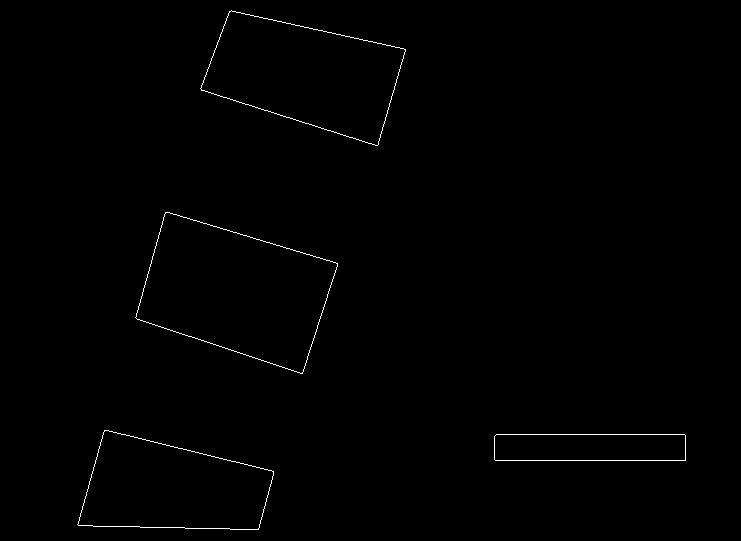


Measurements in progress ... 0
dimX=10000.0nm;  dimY=1361.26nm;


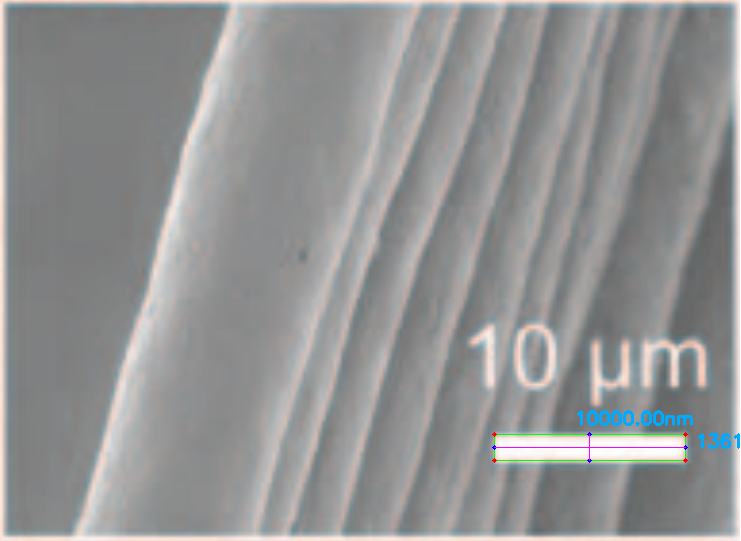


Measurements in progress ... 1
dimX=9751.9nm;  dimY=5260.74nm;


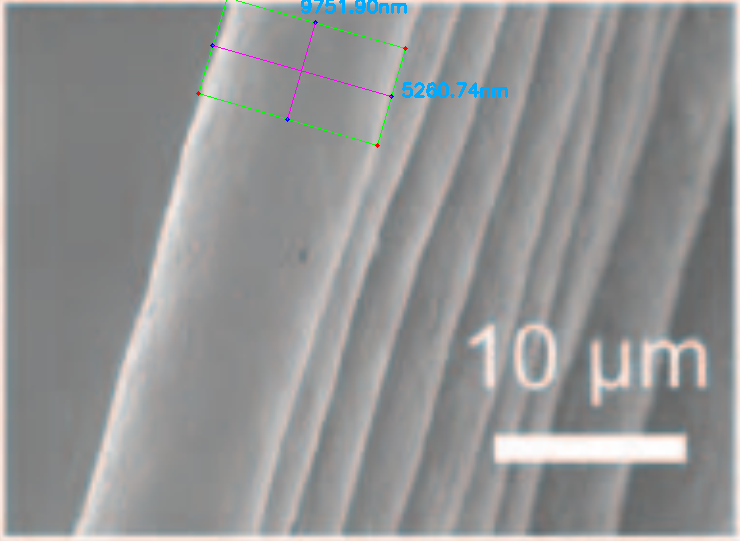


Measurements in progress ... 2
dimX=9429.5nm;  dimY=6101.5nm;


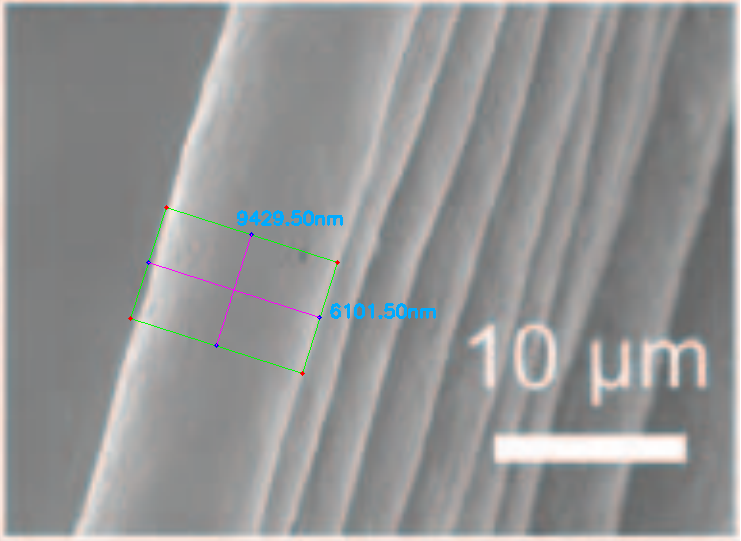


Measurements in progress ... 3
dimX=9377.76nm;  dimY=5206.27nm;


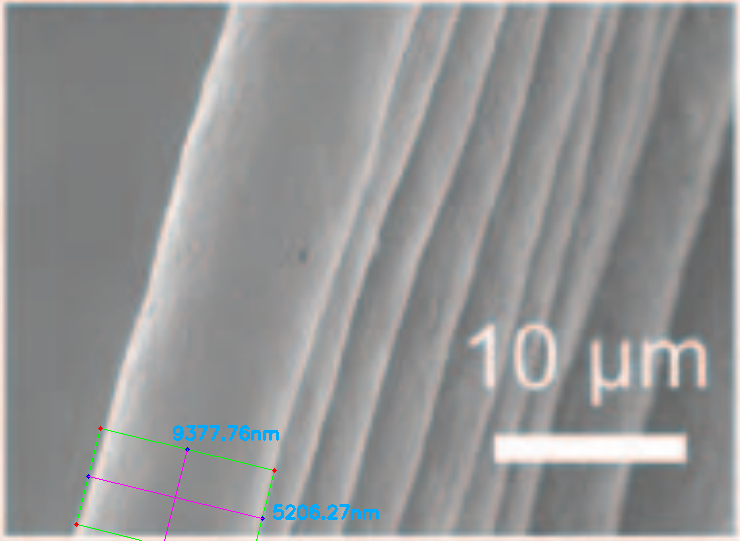

In [8]:
measureImg('./img/Luo2016_01_orig.png',
           './img/Luo2016_01.png',
           True, 0, 10000, #0.00666,
           'edged',
           5,
           True, #T=binary;F=greyscale;
           Threshold=12,
           denoise=0);